In [6]:
from src.scraping.get_data import *
from src.utils.checks import *
from src.portfolio.data_manipulation import *
from src.plots.basics import *
from src.computations.compute_returns import *

In [2]:
download_data_updated()

File downloaded and renamed to MSCI_World.csv
File downloaded and renamed to MSCI_Europe_Small_Cap_Value_Weighted.csv
File downloaded and renamed to MSCI_Europe.csv
File downloaded and renamed to MSCI_ACWI.csv
File downloaded and renamed to S&P_500_Minimum_Volatility.csv
File downloaded and renamed to MSCI_Emerging_Markets.csv
File downloaded and renamed to FTSE_World_Government_Bond_Developed_Markets.csv
File downloaded and renamed to S&P_500.csv
File downloaded and renamed to MSCI_USA_Small_Cap_Value_Weighted.csv
File downloaded and renamed to MSCI_World_Momentum.csv


In [3]:
get_data_info()
data = get_data_updated_2025()

In [4]:
portfolio = { 'MSCI ACWI'                                      : 80-16,
              'FTSE World Government Bond - Developed Markets' : 20,
              'MSCI World Momentum'                            : 8,
              'MSCI USA Small Cap Value Weighted'              : 5,
              'MSCI Europe Small Cap Value Weighted'           : 3,
            }

# portfolio = { 'MSCI ACWI' : 100}

years = 20  # Number of years for the rolling window

ETFs    = list(portfolio.keys())
weights = list(portfolio.values())

data_selected = select_etfs(data, ETFs)
data_selected

,Date,MSCI ACWI,FTSE World Government Bond - Developed Markets,MSCI World Momentum,MSCI USA Small Cap Value Weighted,MSCI Europe Small Cap Value Weighted
238,11/1994,18700.186326,18353.258081,9332.182503,10000.000000,10000.000000
239,12/1994,19149.219099,18232.979437,9575.213960,10405.099245,10301.931555
240,01/1995,18376.155360,18319.483364,9060.974478,10164.392843,10034.275420
241,02/1995,18369.127133,18451.247188,9038.034638,10499.145224,10025.372090
242,03/1995,18464.034250,18615.749694,9209.582136,10216.284938,9878.190237
...,...,...,...,...,...,...
599,12/2024,238077.880001,56892.306595,265746.882999,335259.040664,140723.907556
600,01/2025,245110.877561,56903.160327,278396.282958,347066.971161,147477.720585
601,02/2025,243528.409920,57818.820684,278724.388599,332033.356917,151620.912337
602,03/2025,225203.342503,56062.489396,253014.321457,301474.781370,149258.620455


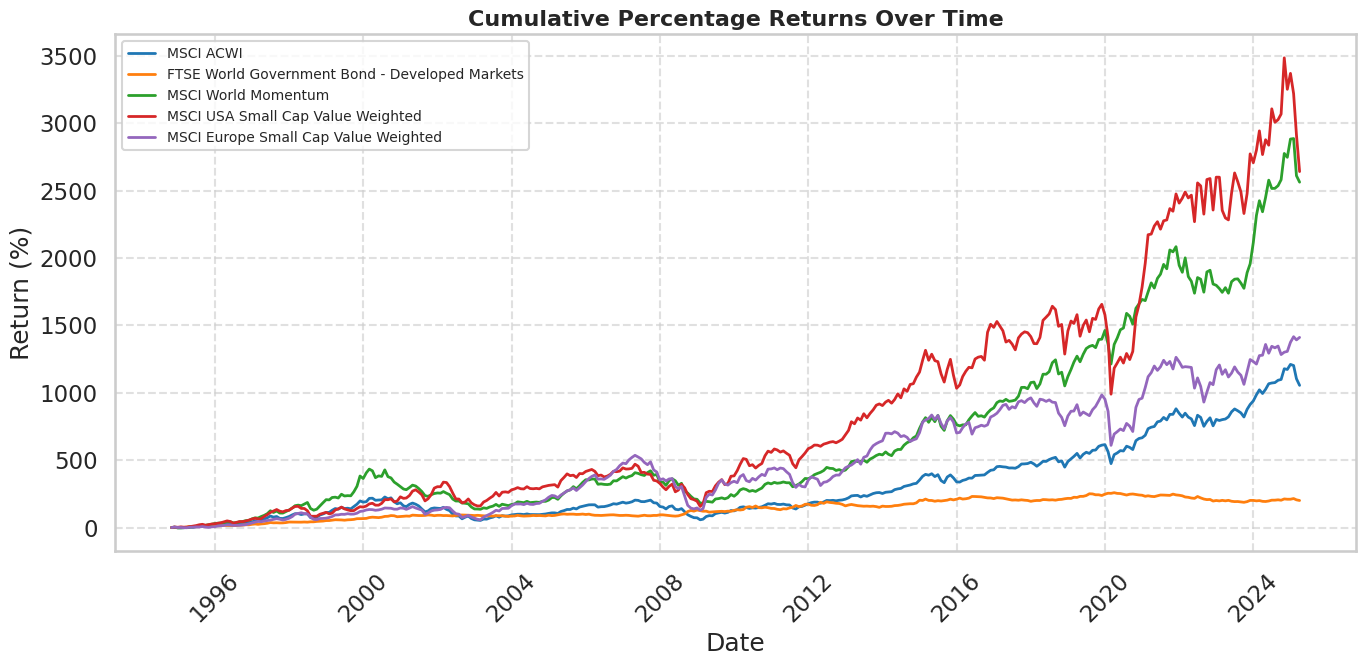

In [5]:
plot_percentage_returns(data_selected)

In [ ]:
def plot_annualized_returns(results):
    """
    Plots the annualized returns of indices over time.
    
    Parameters:
        results (dict or DataFrame): A dictionary or DataFrame containing date-indexed annualized return data.
    """
    df = pd.DataFrame(results)
    
    # Ensure Date column is in datetime format and set it as index
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)
    
    # Plot
    plt.figure(figsize=(15, 7))
    for col in df.columns:
        plt.plot(df.index, df[col]*100, label=col)
    
    plt.xlabel("Date")
    plt.ylabel("Annualized Return (%)")
    plt.title("Annualized Returns of Indices Over Time")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

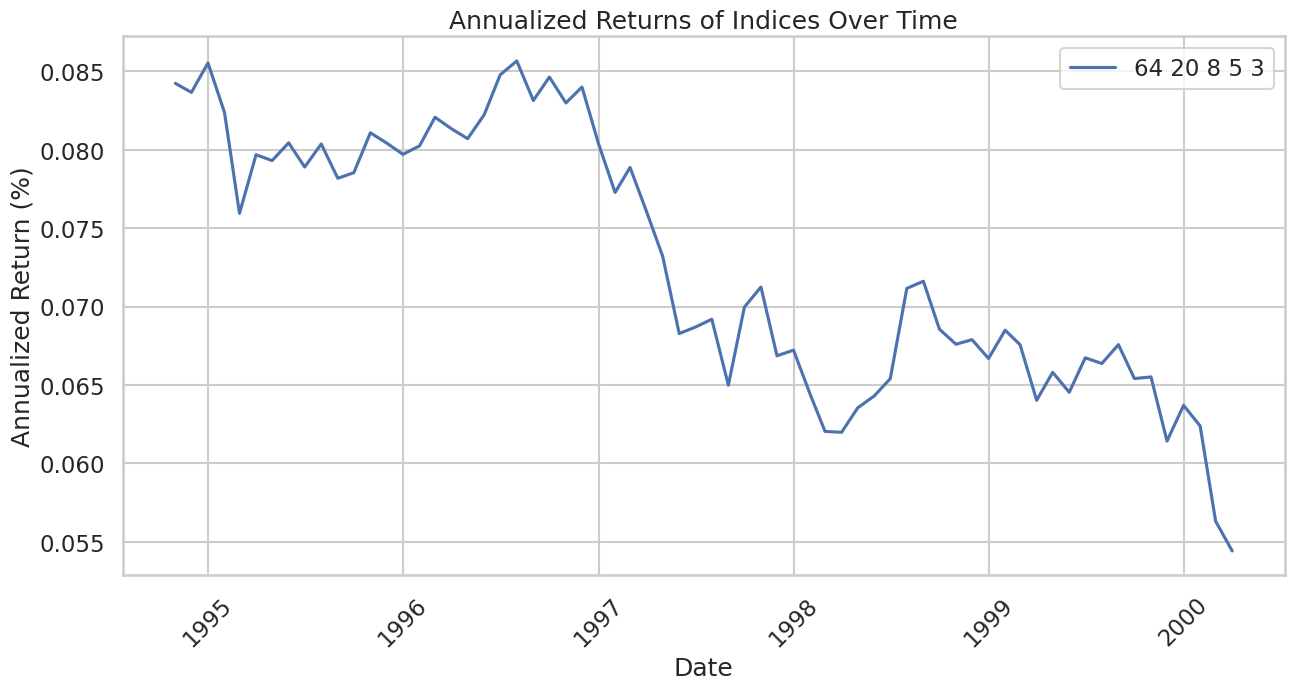

In [11]:
results = compute_portfolio_returns_combined(data_selected, weights, years=25)
plot_annualized_returns(results)